# LEV / GSW overlay

Various methods for overlaying emergent lake vegetation rasters over Pekel/GSW inundation rasters. Occurrence seems to perform better than Seasonality.

In [2]:
## Imports
import geopandas as gpd
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, PowerNorm
from scipy.stats import binned_statistic
import seaborn as sns
from tqdm import tqdm
import numpy as np
import pandas as pd

In [3]:
## Env vars
reclass_vals_detailed = {
    1:	'dry land',
    2:	'water',
    3:	'wet graminoid',
    4:	'wet shrubs',
    5:	'wet forest',
    25: 'river or bridge',
    30: 'urban',
    35: 'non-roi',
    42:	'water no lake',
    43:	'wet graminoid no lake',
    44: 'wet shrubs no lake',
    45: 'wet forest no lake',
    52: 'water not valid'}

reclass_vals_simple = {
    1:	'dry land',
    2:	'water',
    3:	'LEV',
    4:	'LEV',
    5:	'LEV',
    25: 'invalid', 
    30: 'invalid', 
    35: 'invalid', 
    42:	'invalid', 
    43:	'invalid', 
    44: 'invalid', 
    45: 'invalid', 
    52: 'invalid'}

## Method A: Load from GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Zonal histogram based on DN field

In Python:
1. Aggregate by class
2. Compute confusion matrix and plot histograms

In [23]:
## I/O
# region = 'YB'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/YFLATS_190914_mosaic_rcls_brn_zHist_Oc.shp' # this is zonal histogram of YF UAVSAR against GSW Occurrence
# region = 'CSB'
# df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/bakerc_16008_19059_012_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'
region = 'PAD'
df_pth = '/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/zonal_hist/padelE_36000_19059_003_190904_L090_CX_01_Freeman-inc_rcls_brn_zHist_Oc.shp'

## Load
df = gpd.read_file(df_pth) 
df.head()

,DN,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,...,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,HISTO_100,geometry
0,35,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-845123.544 2251261.957, -845117.266..."
1,35,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-845431.127 2251261.957, -845424.850..."
2,35,54.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-845343.246 2251349.838, -845330.692..."
3,35,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-845173.761 2251192.908, -845161.207..."
4,35,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"POLYGON ((-845136.098 2251067.364, -845129.821..."


In [24]:
## Add actual class name
df['Class'] = df['DN'].apply(lambda x: reclass_vals_detailed[x])
df['Broad_class'] = df['DN'].apply(lambda x: reclass_vals_simple[x])

In [25]:
# Aggregate by class (detailed)
dfg = df.groupby('Class')
df_sums = dfg.sum(numeric_only=True)
df_sums.drop(columns='DN', inplace=True) # drop meaningless columns

# Aggregate by class (simple)
dfgs = df.groupby('Broad_class')
df_sums_s = dfgs.sum(numeric_only=True)
df_sums_s.drop(columns='DN', inplace=True)

df_sums_s

,HISTO_0,HISTO_1,HISTO_2,HISTO_3,HISTO_4,HISTO_5,HISTO_6,HISTO_7,HISTO_8,HISTO_9,...,HISTO_91,HISTO_92,HISTO_93,HISTO_94,HISTO_95,HISTO_96,HISTO_97,HISTO_98,HISTO_99,HISTO_100
Broad_class,,,,,,,,,,,,,,,,,,,,,
LEV,141293.0,144.0,714.0,2286.0,3950.0,6085.0,8753.0,7923.0,7585.0,7238.0,...,1265.0,1525.0,1745.0,1289.0,766.0,318.0,207.0,132.0,18.0,0.0
dry land,2221831.0,4824.0,11168.0,8741.0,11304.0,17127.0,16085.0,11252.0,8485.0,7222.0,...,147.0,145.0,201.0,166.0,134.0,79.0,53.0,55.0,13.0,0.0
invalid,6234748.0,1160.0,2265.0,3226.0,5241.0,6773.0,7572.0,7616.0,7113.0,6323.0,...,16600.0,28274.0,46383.0,54885.0,50878.0,36501.0,12180.0,1281.0,93.0,0.0
water,21697.0,81.0,197.0,353.0,375.0,480.0,496.0,599.0,666.0,613.0,...,7304.0,10804.0,14328.0,14605.0,13283.0,16123.0,26805.0,69598.0,56214.0,570.0


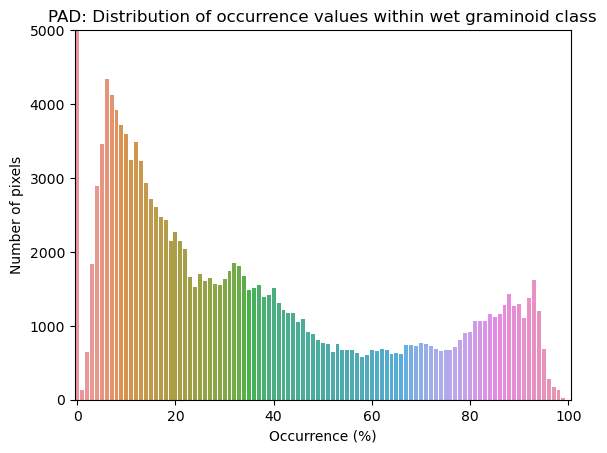

In [26]:
## Plot hist to show: "Within all wet graminoid pixels, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums.loc['wet graminoid', 'HISTO_0':] # 'HISTO_100'
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within wet graminoid class')
plt.show()

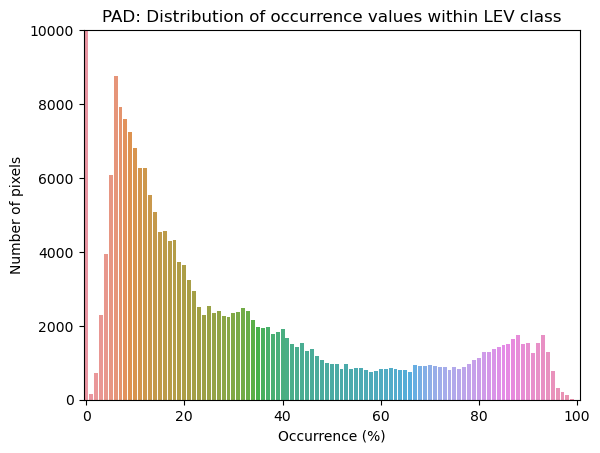

In [29]:
## Plot hist to show: "Within all LEV, what was the distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
hist_wg = df_sums_s.loc['LEV', 'HISTO_0':]
sns.barplot(x=np.arange(df_sums.columns.size), y=hist_wg)
plt.ylim([0, 10000]) #5,000 for most sites, 10,000 for PAD
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence (%)')
plt.ylabel('Number of pixels')
plt.title(f'{region}: Distribution of occurrence values within LEV class')
plt.show()

### Now, group occurrence and calculate confusion matrix

In [30]:
## Compute binned statistic
stats_classes = ['LEV', 'SUM'] # 'water'
df_sums_s.loc['SUM', :]=df_sums_s.sum() # occurence bin
bStat = binned_statistic(np.arange(df_sums.columns.size), values=df_sums_s.loc[stats_classes, :], statistic='sum', bins=[0, 5, 50, 95, 100]) # 
df_sums_s.loc['oc_bin', :]=np.nan # occurence bin
df_sums_s
bStat


BinnedStatisticResult(statistic=array([[1.483870e+05, 1.506880e+05, 4.790000e+04, 1.441000e+03],
       [8.675598e+06, 4.634260e+05, 4.379310e+05, 2.853010e+05]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4]))

In [31]:
## Construct Confusion Matrix

cm = pd.DataFrame(bStat.statistic[:2], columns = bStat.bin_edges[1:], index = stats_classes[:2])
cm.loc['Other', :] = cm.loc['SUM',:] - cm.loc['LEV', :]
cm.reindex(cm.index[[0,2,1]])

## Construct Confusion Matrix with water
# cm_full = pd.DataFrame(bStat.statistic, columns = bStat.bin_edges[1:], index = stats_classes)
# cm_full.loc['Other', :] = cm_full.loc['SUM',:] - cm_full.loc['LEV', :]
# cm_full.reindex(cm_full.index[[0,2,1]])

,5.0,50.0,95.0,100.0
LEV,148387.0,150688.0,47900.0,1441.0
Other,8527211.0,312738.0,390031.0,283860.0
SUM,8675598.0,463426.0,437931.0,285301.0


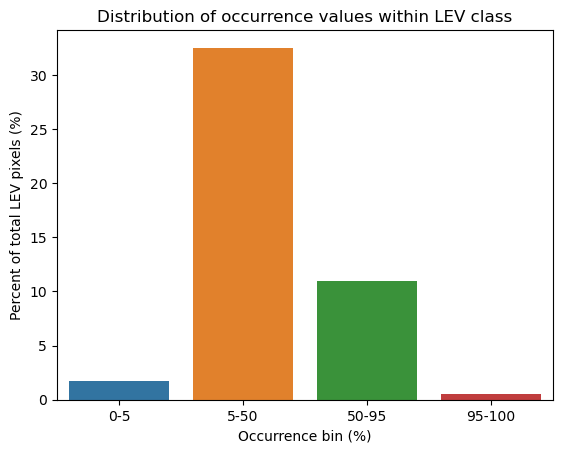

In [32]:
## Plot binned stat
## Plot hist to show: "Within all LEV, what was the binned distribution of occurrence values"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)
# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title('Distribution of occurrence values within LEV class')
plt.show()



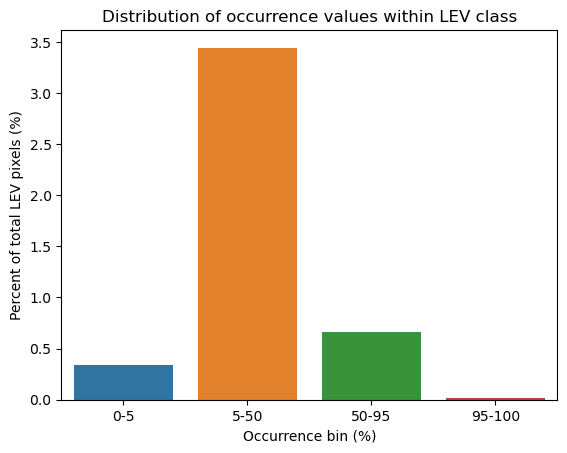

In [ ]:
## Plot binned stat in other dimension
## Plot hist to show: "Within all of one occurrence bin, what was the contribution of LEV values"
'''Almost all WG pixels have 0 occurrence...'''
bin_labels = ['0-5', '5-50', '50-95', '95-100']
sns.barplot(x=cm.columns, y=cm.loc['LEV', :] / cm.loc['SUM', :] * 100)
# plt.ylim([0, 5000])
plt.xticks(ticks=plt.xticks()[0][::20])
plt.xlabel('Occurrence bin (%)')
plt.xticks(ticks=np.arange(4), labels = bin_labels)
plt.ylabel('Percent of total LEV pixels (%)')
plt.title('Distribution of occurrence values within LEV class')
plt.show()



### Try to visualize confusion matrix

In [146]:
cm.iloc[:2, :-1].

,0-5,5-50,50-95,95-100
LEV,171108.0,57047.0,14811.0,223.0
SUM,50507184.0,1657152.0,2227264.0,1062964.0


KeyError: (0, 0)

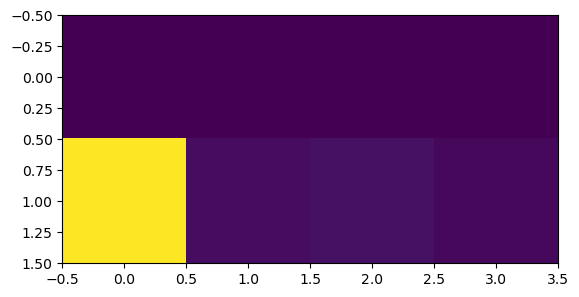

In [130]:
## Visualize CM
from sklearn.metrics import ConfusionMatrixDisplay
cmD = ConfusionMatrixDisplay(cm.iloc[:2, :])
# cmD.
cmD.plot()

### CM viz V2

In [152]:
## Add row sum
# cm.columns = ['0-5', '5-50', '50-95', '95-100'] # comment out if already run
# cm['SUM'] = cm.sum(axis=1)
cm.astype('int')

,0-5,5-50,50-95,95-100,SUM
LEV,171108,57047,14811,223,243189
SUM,50507184,1657152,2227264,1062964,55454564
Other,50336076,1600105,2212453,1062741,55211375


KeyError: (0, 0)

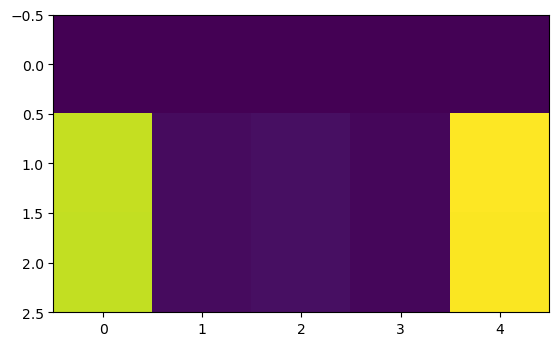

In [148]:
cmD = ConfusionMatrixDisplay(cm)
# cmD = ConfusionMatrixDisplay(cm.iloc[:2, :4])
# cmD.
cmD.plot()

## Method B: Load from lengthy GIS operations
In QGIS:
1. Polygonize burned UAVSAR raster
2. Dissolve based on DN field to get only n entries corresponding to n classes
2. Zonal histogram based on DN field

In [30]:
## Load file that has already been aggregated through verrry slow QGIS dissolve by DN
df = gpd.read_file('/mnt/g/Ch4/misc/UAVSAR_polygonized/sub_roi/dissolved/zonal_hist/YFLATS_190914_mosaic_rcls_brn_ds_Occurrence.shp')
df.head()

,DN,geometry
0,35,"MULTIPOLYGON (((-2017546.705 3712282.011, -201..."
1,5,"MULTIPOLYGON (((-2034859.024 3717013.819, -203..."
2,4,"MULTIPOLYGON (((-2057236.298 3723637.221, -205..."
3,3,"MULTIPOLYGON (((-2058766.512 3723947.781, -205..."
4,2,"MULTIPOLYGON (((-2059381.986 3723834.850, -205..."
